In [1]:
import pandas as pd
import numpy as np
import itertools as it

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as mtick

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.stats.outliers_influence import variance_inflation_factor

from patsy import dmatrices

pd.set_option('display.max_columns',70)
plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

### Helper functions and variables

In [2]:
def get_ci(df, col, gb_col='date', percentile='95'):
    if percentile == '999':
        cival = 3.291
    if percentile == '995':
        cival = 2.807
    if percentile == '99':
        cival = 2.576
    if percentile == '95':
        cival = 1.96
    if percentile == '90':
        cival = 1.645
    if percentile == '80':
        cival = 1.282

    df_stats = df.groupby(gb_col)[col].agg([np.nanmean,'count',np.nanstd])
    ci95_hi = []
    ci95_lo = []
    for i in df_stats.index:
        m, c, s = df_stats.loc[i]
        ci95_hi.append(m + cival*s/np.sqrt(c))
        ci95_lo.append(m - cival*s/np.sqrt(c))
    df_stats['ci95_hi'] = ci95_hi
    df_stats['ci95_lo'] = ci95_lo

    return df_stats.reset_index()

In [3]:
all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}
all_names_state = {j:i for i,j in all_state_names.items()}

In [4]:
month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

today = str(dt.datetime.date(dt.datetime.now()))

# make DATE_DF, a simple dataframe with dates, weekdays, and weeknums
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                   4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-01', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()
date_dict = dict(zip(DATERANGE,list(range(len(DATERANGE)))))

# Import and prepare data for analyses

In [5]:
ihe_df    = pd.read_csv('../data/campus_covid_fall2020_full.csv', dtype={'ipeds_id':str, 'fips':str})
ipeds_df  = pd.read_csv('../data/campus_covid_ipeds.csv',         dtype={'ipeds_id':str, 'fips':str})
status_df = pd.read_csv('../data/campus_covid_status.csv',        dtype={'ipeds_id':str, 'fips':str})
census_df = pd.read_csv('../data/campus_covid_census.csv',        dtype={'fips':str})
jhu_df    = pd.read_csv('../data/campus_covid_jhu_county.csv.gz', dtype={'fips':str})

summary_df = status_df.groupby(['fips','status_merge']
                               ).agg({'ihe_fulltime_population':'sum'}).reset_index()
summary_df = summary_df.merge(jhu_df[['fips','county_population']].drop_duplicates(),
                              how='left', on='fips')
summary_df['enrollment_fulltime'] = summary_df['ihe_fulltime_population']
summary_df['total_pop'] = summary_df['county_population']
summary_df['frac_pop_enrollment_fulltime'] = summary_df['enrollment_fulltime']/summary_df['total_pop']

summary_df['fraction_status'] = summary_df['frac_pop_enrollment_fulltime']
summary_df['status'] = summary_df['status_merge']

summary_df.head()

,fips,status_merge,ihe_fulltime_population,county_population,enrollment_fulltime,total_pop,frac_pop_enrollment_fulltime,fraction_status,status
0,01003,Primarily Online,3854,223234,3854,223234,0.017264,0.017264,Primarily Online
1,01015,Primarily Online,6738,113605,6738,113605,0.059311,0.059311,Primarily Online
2,01031,Primarily Online,1039,52342,1039,52342,0.019850,0.019850,Primarily Online
3,01033,Hybrid,1654,55241,1654,55241,0.029942,0.029942,Hybrid
4,01035,Primarily Online,209,12067,209,12067,0.017320,0.017320,Primarily Online


In [6]:
percent_thresh = 0.03683369933503948

fips_inperson = summary_df.loc[(summary_df['frac_pop_enrollment_fulltime']>percent_thresh)&\
                               (summary_df['status_merge']=='Primarily In Person')]['fips'].unique()
print(len(fips_inperson),'in person')

fips_online = summary_df.loc[(summary_df['frac_pop_enrollment_fulltime']>percent_thresh)&\
                             (summary_df['status_merge']=='Primarily Online')]['fips'].values
fips_online = [i for i in fips_online if i not in fips_inperson]
print(len(fips_online),'online')

college_county_fips = list(fips_online) + list(fips_inperson)

df = pd.read_csv('../data/analysis.csv.gz', dtype={'fips':str})
print(df.shape)

234 in person
221 online
(339212, 47)


## Add a column for d-lagged deaths

In [7]:
dlag = 27
tmpx = df[['fips','date','county_new_deaths_per100k']].copy()
tmpx['date'] = [DATERANGE[date_dict[i]-dlag] for i in tmpx['date']]
tmpo = tmpx.rename(columns={'county_new_deaths_per100k':\
                            'county_new_deaths_per100k_lagged_%i'%dlag})
tmpo.loc[tmpo['county_new_deaths_per100k_lagged_%i'%dlag]<0.0,
         'county_new_deaths_per100k_lagged_%i'%dlag] = 0.0

for dlag in list(range(28,40)):
    tmpx = df[['fips','date','county_new_deaths_per100k']].copy()
    tmpx['date'] = [DATERANGE[date_dict[i]-dlag] for i in tmpx['date']]
    tmpx = tmpx.rename(columns={'county_new_deaths_per100k':\
                                'county_new_deaths_per100k_lagged_%i'%dlag})
    tmpx.loc[tmpx['county_new_deaths_per100k_lagged_%i'%dlag]<0.0,
                  'county_new_deaths_per100k_lagged_%i'%dlag] = 0.0
    tmpo = tmpo.merge(tmpx, how='left', on=['fips','date'])

start_date_reg = '2020-08-15'
final_date_reg = '2020-12-15'
out_dfx = df.loc[(df['date']>=start_date_reg)&\
                 (df['date']<=final_date_reg)].copy()

tmpo = tmpo.loc[(tmpo['date']>=start_date_reg)&\
                (tmpo['date']<=final_date_reg)].copy()
df = out_dfx.merge(tmpo,how='left',on=['fips','date'])
print(df.shape)

(152274, 60)


## Add scaling to IHE variables (log and per 100k)

In [8]:
ihe_population_vars = ['county_ihe_fulltime_population',
                       'county_ihe_fulltime_population_online',
                       'county_ihe_fulltime_population_hybrid',
                       'county_ihe_fulltime_population_inperson']

for v in ihe_population_vars:
    df[v+"_per100k"] = df[v] / df['county_pop'] * 100000
    df[v+"_per100k_log"] = np.log(df[v+"_per100k"]+1)

print(df.shape)

(152274, 68)


## Add scaling to IHE COVID-19 variables (log and per 100k)

In [9]:
ihe_covid_vars = ['ihe_cumulative_cases','ihe_cumulative_tests',
                  'ihe_total_tests','ihe_positive_tests']

for v in ihe_covid_vars:
    df.loc[df[v].isna(),v] = 0.0
    df[v+"_per100k"] = df[v] / df['county_pop'] * 100000
    df[v+"_per100k_log"] = np.log(df[v+"_per100k"]+1)

print(df.shape)

(152274, 76)


## Add scaling to county-level COVID-19 variables

In [10]:
county_covid_vars = ['county_new_tests','county_new_cases']

for v in county_covid_vars:
    df.loc[df[v].isna(),v] = 0.0
    df.loc[df[v]<0.0,v] = 0.0
    df[v+"_per100k"] = df[v] / df['county_pop'] * 100000
    df[v+"_per100k_log"] = np.log(df[v+"_per100k"]+1)

df_cases_tmp = df.groupby('fips').agg({'county_new_cases_per100k':'sum'}).reset_index()
df_cases_tmp = df_cases_tmp.rename(columns={'county_new_cases_per100k':'county_cumulative_cases_per100k'})
df = df.merge(df_cases_tmp, how='left',on='fips')

# turn percent*100 into a per100k measure, only mult by 1000
df['county_age_under_29_per100k'] = df['county_fracpop_age_under_29']*1000
df['county_age_above_60_per100k'] = df['county_fracpop_age_above_60']*1000
df['county_age_under_29_per100k_log'] = np.log(df['county_age_under_29_per100k'])
df['county_age_above_60_per100k_log'] = np.log(df['county_age_above_60_per100k'])

df['county_median_income_log'] = np.log(df['county_median_income'])
df['log_pop_density'] = np.log(df['county_pop_density'])
print(df.shape)

(152274, 87)


## Create indicator variables

In [11]:
df['yestest_notest'] = 1
df.loc[df['ihe_cumulative_tests']==0,'yestest_notest'] = 0

df['county_rural'] = 0
df.loc[df['county_urban_rural']>3,'county_rural'] = 1
print(df.shape)

(152274, 89)


## Subset to only the counties included in this study

In [12]:
df = df.loc[df['fips'].isin(college_county_fips)].reset_index().iloc[:,1:].copy()

## Add vote data

In [13]:
tmp_elec = pd.read_csv('/Users/brennan/Downloads/countypres_2000-2020.csv',dtype={'county_fips':'str'})
tmp_elec = tmp_elec.loc[tmp_elec['year']==2020].copy().reset_index().iloc[:,1:]
tmp_elec = tmp_elec.rename(columns={"county_fips":'fips'})
tmp_elec = tmp_elec.loc[tmp_elec['fips'].isin(df['fips'].unique())].copy().reset_index().iloc[:,1:]
tmp_elec['trump_votes'] = tmp_elec['candidatevotes']
tmp_elec['total_votes'] = tmp_elec['totalvotes']
tmp_elec = tmp_elec.loc[tmp_elec['candidate']=='DONALD J TRUMP'].copy().reset_index().iloc[:,1:]
tmp_elec = tmp_elec[['fips','trump_votes','total_votes']].copy()
# tmp_elec = tmp_elec.groupby('fips').agg({'trump_votes':'sum','total_votes':'sum'}).reset_index()
tmp_elec = tmp_elec.groupby('fips').agg({'trump_votes':'sum','total_votes':'max'}).reset_index()
tmp_elec = tmp_elec.merge(df[['fips','county_pop']].drop_duplicates(), how='left', on='fips')

tmp_elec = tmp_elec[tmp_elec['total_votes']>0.0].copy().reset_index().iloc[:,1:]
tmp_elec['trump_voteshare'] = tmp_elec['trump_votes'] / tmp_elec['total_votes'] * 100
tmp_elec['trump_votes_per100k'] = tmp_elec['trump_votes'] / tmp_elec['county_pop'] * 100000
tmp_elec = tmp_elec[['fips','trump_votes','trump_voteshare','trump_votes_per100k']].copy()

df = df.merge(tmp_elec, how='left', on='fips')

df['trump_votes_per100k_log'] = np.log(df['trump_votes_per100k'])
print(df.shape)

(55965, 93)


## Create aggregate policy columns

In [14]:
policy_cols = ['school_closing',
               'workplace_closing',
               'cancel_public_events',
               'restrictions_on_gatherings',
               'public_transport_closing',
               'stay_at_home_requirements',
               'restrictions_on_internal_movement',
               'international_travel_controls',
               'facial_coverings',
]

for ap in policy_cols:
    df[ap] = df[ap].astype(float)
df['active_policies'] = (df[policy_cols]>0).sum(axis=1)
df['active_policies_sum'] = df[policy_cols].sum(axis=1)

df.shape

(55965, 93)

## Create labels of variables

In [15]:
var_labels = {'log_pop_density':             'log(population density)',
              'county_age_under_29_per100k_log': 'log(population under 29 per 100k)',
              'county_age_above_60_per100k_log': 'log(population over 60 per 100k)',
              'county_median_income_log':    'log(median income)',
              'county_rural':                'urban/rural code (1 if $\\in \\{4,5,6\\}$ else 0)',
              'average_temperature_celsius': 'average temperature ($^\\circ$Celsius)',
              'stringency_index':            'stringency index (OxCGRT)',
              'trump_voteshare': '2020 voting behavior (% Rep.)',
              'county_ihe_fulltime_population_per100k_log': 'log(IHE fulltime enrollment per 100k)',
              'county_ihe_fulltime_population_online_per100k_log': 'log(IHE fulltime enrollment per 100k (online))',
              'county_ihe_fulltime_population_inperson_per100k_log': 'log(IHE fulltime enrollment per 100k (in person))',
              'county_new_tests_per100k_log':'log(county new tests per 100k)',
              'ihe_total_tests_per100k_log':'log(IHE new tests per 100k)',
              'const':'intercept'
}
for v in [i for i in df.columns if 'lagg' in i]:
    var_labels[v] = 'new deaths per 100k, %s-day lag'%v.split('_')[-1]

# Negative Binomial Regression

While the two groups of counties---the "primarily in-person" vs. "primarily online" counties---are broadly similar across demographic categories, there could still be underlying differences between the two groups that influence their different COVID-19 outcomes. For example, this could happen if the two groups differed in the extent to which they enacted mitigation policies (i.e., if there were a common variable influencing whether a given county introduced mitigation policies as well as whether IHEs in the county remained primarily online vs. in-person during the Fall 2020 semester). There are a number of possible sources of this variability, ranging from differences in population density (Smithe et al, 2021), to differences in messaging from political leaders (Green et al., 2020). In the model below, we include the data about voting patterns in the 2020 presidential election in order to control for potential biases arising from differences in political behavior at the county level.

To control for potential biases arising from differences in local mitigation policies, we assigned each county to an "active mitigation policies" score based on policy tracking data from the Oxford COVID-19 Government Response Tracker (Hale et al., 2021). These are daily time series data indicating whether or not a number of different policies were active on each day for a given state. Not only does this dataset list the presence or absence of a given policy, it also includes information about the severity (e.g. restrictions on gatherings of 10 people vs. restrictions on gatherings of 100 people, or closing all non-essential workplaces vs. closing specific industries, etc.). From these indicator variables, Hale et al. (2021) define a summary "stringency index" that characterizes the daily intensity of the mitigation policies that a given region is undergoing over time. We include this "stringency index" variable in an Generalized Linear Model regression to quantify the extent to which this time series of policy measures---along with data about IHE testing and enrollment policy, demographic data about the county itself, and average temperature---predicts COVID-19-related deaths (below).

<!--  \cite{Smithe2021}
 \cite{Green2020}
 \cite{Hale2021} -->

In [16]:
# endog_var = ['county_new_deaths_per100k_lagged_38']

exog_var = ['average_temperature_celsius',
            'county_rural',
            'log_pop_density',
            'county_median_income_log',
            'trump_voteshare',
            'county_age_above_60_per100k_log',
            'county_ihe_fulltime_population_per100k_log',
            'county_ihe_fulltime_population_online_per100k_log',
            'county_ihe_fulltime_population_inperson_per100k_log',
            'stringency_index',
            'county_new_tests_per100k_log',
            'ihe_total_tests_per100k_log',
           ]

## Examine the distributions of the variables used in the regression

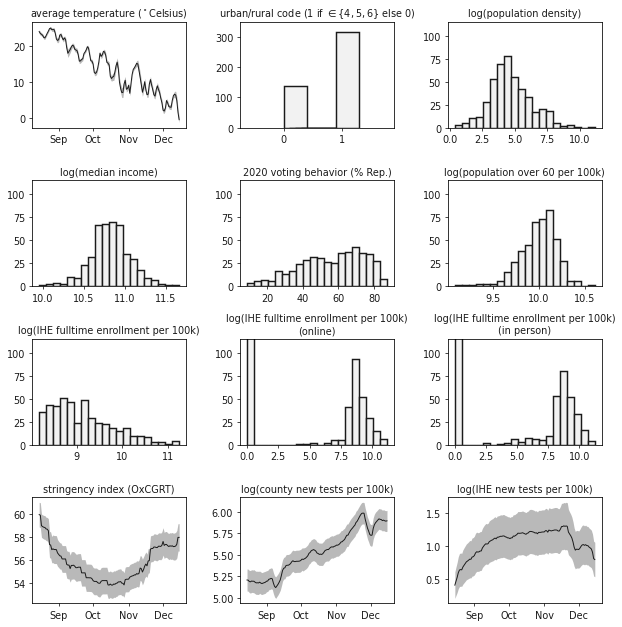

In [17]:
w = 3.5
h = 2.75
ncols = 3
nrows = 4
tups = list(it.product(range(nrows), range(ncols)))

col_co = '.1'
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=70)
plt.subplots_adjust(wspace=0.35,hspace=0.5)

for ix, var in enumerate(exog_var):#+endog_var):
    tmp_df = df[['fips',var]].drop_duplicates().reset_index().iloc[:,1:]
#     print(tmp_df.shape)
    if tmp_df.shape[0]!=455:
        lcol = '.1'
        varx = var
        tmp_dfx = df[['fips','date',varx]].drop_duplicates().reset_index().iloc[:,1:]
        tmp_dfg = get_ci(tmp_dfx, varx, percentile='999')

        ax[tups[ix]].plot([date_dict[i] for i in tmp_dfg['date']],
                          tmp_dfg['nanmean'], lw=1, color=lcol)
        ax[tups[ix]].fill_between([date_dict[i] for i in tmp_dfg['date']],
                                   tmp_dfg['ci95_lo'].values,tmp_dfg['ci95_hi'].values,
                                  alpha=0.3, lw=0, color=lcol)
        ax[tups[ix]].set_xticks([date_dict[i] for i in ['2020-09-01','2020-10-01',
                                                        '2020-11-01','2020-12-01']])
        ax[tups[ix]].set_xticklabels(['Sep','Oct','Nov','Dec'])
        
    else:
        ylim = 115
        if tmp_df[var].nunique()<3:
            ylim = 350
            xlims = [-0.75, 1.90]
            ax[tups[ix]].set_xlim(xlims[0],xlims[1])
            bw = 0.4
            ax[tups[ix]].hist(tmp_df[var].values,width=bw,ec='.1',color='.95',lw=1.5)
        else:
            ax[tups[ix]].hist(tmp_df[var].values,bins=20,ec='.1',color='.95',lw=1.5)

        ax[tups[ix]].set_ylim(0,ylim)

    tmp_title = var_labels[var]
    tmp_title = tmp_title.replace(' (online))',')\n(online)')
    tmp_title = tmp_title.replace(' (in person))',')\n(in person)')
    ax[tups[ix]].set_title(tmp_title, fontsize='medium', color='.1')
    ax[tups[ix]].tick_params(labelcolor='.1', color='.1')

# plt.savefig('../figs/pngs/regression_SI_campuscovid_vars.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/regression_SI_campuscovid_vars.pdf',bbox_inches='tight')
plt.show()

____________________

## Find lag that maximizes Pearson chi2

In [18]:
out_rvs1 = {}
out_rvs2 = {}
for endog_var_i in sorted([i for i in df.columns if 'lagg' in i]):
    endog_var = [endog_var_i]
    out_dfx = df.loc[df['fips'].isin(college_county_fips)].reset_index().iloc[:,1:].copy()
    endog_df = out_dfx[['date']+endog_var].copy()
    for endog_i in endog_var:
        endog_df[endog_i] = np.array(np.nan_to_num(endog_df[endog_i].values), dtype='float')

    smdates = dates_from_str(endog_df['date'])
    endog_df.index = pd.DatetimeIndex(smdates)
    endog_df = endog_df[[i for i in endog_df.columns if i!='date']]

    exog_df = out_dfx[['date']+exog_var].copy()
    for exog_i in exog_var:
        exog_df[exog_i] = np.array(np.nan_to_num(exog_df[exog_i].values), dtype='float')

    smdates = dates_from_str(exog_df['date'])
    exog_df.index = pd.DatetimeIndex(smdates)
    exog_df = exog_df[[i for i in exog_df.columns if i!='date']]

    # without constant
    # exog_df = sm.add_constant(exog_df)
    nebin_model = sm.GLM(endog_df, exog_df, family=sm.families.NegativeBinomial())
    results = nebin_model.fit()
    out_rvs1[int(endog_var_i.split('_')[-1])] = results.pearson_chi2

    # with constant
    exog_df = sm.add_constant(exog_df)
    nebin_model = sm.GLM(endog_df, exog_df, family=sm.families.NegativeBinomial())
    results = nebin_model.fit()
    out_rvs2[int(endog_var_i.split('_')[-1])] = results.pearson_chi2
    print(endog_var_i, dt.datetime.now())

county_new_deaths_per100k_lagged_27 2021-09-02 07:55:13.504763
county_new_deaths_per100k_lagged_28 2021-09-02 07:55:23.038657
county_new_deaths_per100k_lagged_29 2021-09-02 07:55:32.597220
county_new_deaths_per100k_lagged_30 2021-09-02 07:55:42.228817
county_new_deaths_per100k_lagged_31 2021-09-02 07:55:50.950058
county_new_deaths_per100k_lagged_32 2021-09-02 07:55:59.954295
county_new_deaths_per100k_lagged_33 2021-09-02 07:56:09.058396
county_new_deaths_per100k_lagged_34 2021-09-02 07:56:18.046957
county_new_deaths_per100k_lagged_35 2021-09-02 07:56:26.495624
county_new_deaths_per100k_lagged_36 2021-09-02 07:56:34.741900
county_new_deaths_per100k_lagged_37 2021-09-02 07:56:43.337207
county_new_deaths_per100k_lagged_38 2021-09-02 07:56:52.683532
county_new_deaths_per100k_lagged_39 2021-09-02 07:57:01.359978


In [19]:
max_chi = max(out_rvs1, key=out_rvs1.get)
print("maximized at %i-day lag"%max_chi)
endog_var = ['county_new_deaths_per100k_lagged_%s'%(str(max_chi))]

maximized at 38-day lag


In [20]:
out_dfx = df.loc[df['fips'].isin(college_county_fips)].reset_index().iloc[:,1:].copy()
endog_df = out_dfx[['date']+endog_var].copy()
for endog_i in endog_var:
    endog_df[endog_i] = np.array(np.nan_to_num(endog_df[endog_i].values),
                                 dtype='float')

smdates = dates_from_str(endog_df['date'])
endog_df.index = pd.DatetimeIndex(smdates)
endog_df = endog_df[[i for i in endog_df.columns if i!='date']]

exog_df = out_dfx[['date']+exog_var].copy()
for exog_i in exog_var:
    exog_df[exog_i] = np.array(np.nan_to_num(exog_df[exog_i].values),
                               dtype='float')

smdates = dates_from_str(exog_df['date'])
exog_df.index = pd.DatetimeIndex(smdates)
exog_df = exog_df[[i for i in exog_df.columns if i!='date']]
# exog_df = sm.add_constant(exog_df)

nebin_model = sm.GLM(endog_df, exog_df, family=sm.families.NegativeBinomial())
results = nebin_model.fit()

results_summary = results.summary(xname=[var_labels[i]
                                         for i in nebin_model.data.xnames],
                                  yname=var_labels[endog_var[0]])
results_as_html = results_summary.tables[1].as_html()
res_i = pd.read_html(results_as_html, header=0, index_col=0)[0]
res_i = res_i.reset_index()
res_i.columns = ['var','coef','std_err','z','pval','ci025','ci975']
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Generalized Linear Model Regression Results                        
===========================================================================================
Dep. Variable:     new deaths per 100k, 38-day lag   No. Observations:                55965
Model:                                         GLM   Df Residuals:                    55953
Model Family:                     NegativeBinomial   Df Model:                           11
Link Function:                                 log   Scale:                          1.0000
Method:                                       IRLS   Log-Likelihood:                -62606.
Date:                             Thu, 02 Sep 2021   Deviance:                       31395.
Time:                                     07:57:09   Pearson chi2:                 4.15e+04
No. Iterations:                                  9                                         
Covariance Type:                         nonrobust                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
average temperature ($^\circ$Celsius)                -0.0393      0.001    -45.198      0.000      -0.041      -0.038
urban/rural code (1 if $\in \{4,5,6\}$ else 0)        0.0952      0.021      4.536      0.000       0.054       0.136
log(population density)                              -0.0159      0.006     -2.516      0.012      -0.028      -0.004
log(median income)                                   -0.4707      0.027    -17.744      0.000      -0.523      -0.419
2020 voting behavior (% Rep.)                         0.0124      0.001     24.399      0.000       0.011       0.013
log(population over 60 per 100k)                      0.4898      0.029     17.139      0.000       0.434       0.546
log(IHE fulltime enrollment per 100k)                -0.1029      0.012     -8.938      0.000      -0.125      -0.080
log(IHE fulltime enrollment per 100k (online))        0.0082      0.003      2.421      0.015       0.002       0.015
log(IHE fulltime enrollment per 100k (in person))     0.0110      0.003      3.297      0.001       0.004       0.018
stringency index (OxCGRT)                            -0.0179      0.001    -19.274      0.000      -0.020      -0.016
log(county new tests per 100k)                        0.2664      0.010     27.462      0.000       0.247       0.285
log(IHE new tests per 100k)                          -0.0390      0.004     -9.092      0.000      -0.047      -0.031
=====================================================================================================================
"""

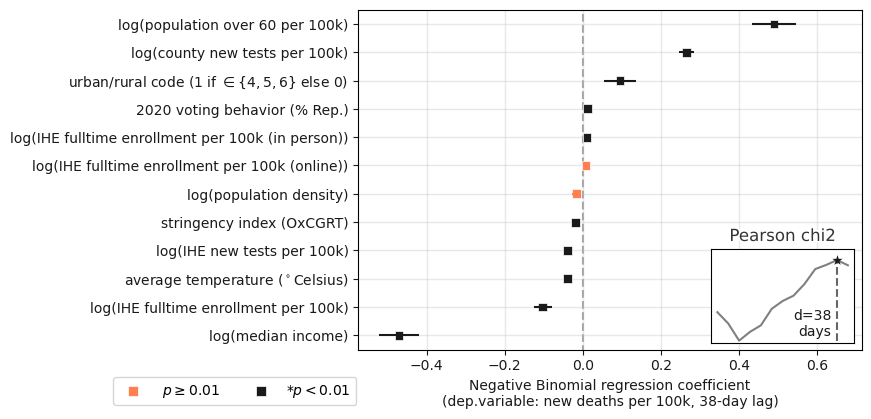

In [21]:
res_i = res_i.sort_values('coef', ascending=True).reset_index().iloc[:,1:]
pval_lim = 0.01
res_i['color'] = '.1'
res_i.loc[res_i['pval']>pval_lim,'color'] = 'coral'

fig, ax = plt.subplots(1,1,figsize=(6.5,4.5),dpi=100)

ax.scatter([-50],[0],
           marker='s',lw=0.5,s=50, c='coral', ec='w',label=r' $p \geq 0.01$')
ax.scatter([-50],[0],
           marker='s',lw=0.5,s=50, c='.1', ec='w',label=r'$*p < 0.01$')
ax.legend(loc=2, bbox_to_anchor=[-0.5,-0.06], ncol=2)

ax.scatter(res_i['coef'].values, list(range(res_i.shape[0])),
           marker='s',lw=0.5,s=40, color=res_i['color'].values, ec='w')
ax.hlines(list(range(res_i.shape[0])),
          res_i['ci025'].values,
          res_i['ci975'].values, color=res_i['color'].values)
ax.vlines(0, -1, len(list(range(res_i.shape[0])))+0.5,
          color='.4', linestyle='--', zorder=0, alpha=0.6)

ax.tick_params(labelcolor='.1', color='.1')
ax.set_yticks(list(range(res_i.shape[0])))
ax.set_yticklabels([i for i in res_i['var'].values], color='.1')
ax.set_ylim(-0.5, len(list(range(res_i.shape[0])))-0.5)
ax.grid(linewidth=1.0, color='.75', alpha=0.35)
ax.set_xlabel('Negative Binomial regression coefficient\n(dep.'+\
              'variable: %s)'%var_labels[endog_var[0]], color='.1')
ax.set_xlim(-0.575, 0.715)

axi = ax.inset_axes([0.7, 0.02, 0.285, 0.275], transform=ax.transAxes)
axi.plot(list(out_rvs1.keys()),list(out_rvs1.values()), color='.5')
axi.scatter([max_chi],[out_rvs1[max_chi]], c='.1', marker='*', s=60, zorder=10,lw=0)
axi.vlines([max_chi],min(out_rvs1.values()),[out_rvs1[max_chi]],ls='--', color='.4')
axi.set_ylim(min(out_rvs1.values())*0.999,out_rvs1[max_chi]*1.005)
axi.text(max_chi-0.5, min(out_rvs1.values())*1.001, "d=%i\ndays"%max_chi,
         color='.1', ha='right', va='bottom')
axi.set_xticks([])
axi.set_yticks([])
pe2 = [path_effects.Stroke(linewidth=2.5, foreground='w'), path_effects.Normal()]
axi.set_title('Pearson chi2', path_effects=pe2, color='.2')

# plt.savefig('../figs/pngs/regression_SI_campuscovid_negativeBinomial.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/regression_SI_campuscovid_negativeBinomial.pdf',bbox_inches='tight')
plt.show()

In [22]:
print(results_summary.as_latex().replace('  ',' ').replace('  ',' '
                        ).replace('  ',' ').replace('  ',' ').replace('  ',' '))

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}  & new deaths per 100k, 38-day lag & \textbf{ No. Observations: } & 55965 \\
\textbf{Model:}  & GLM & \textbf{ Df Residuals: } & 55953 \\
\textbf{Model Family:}  & NegativeBinomial & \textbf{ Df Model: } & 11 \\
\textbf{Link Function:}  & log & \textbf{ Scale: } & 1.0000 \\
\textbf{Method:}  & IRLS & \textbf{ Log-Likelihood: } & -62606. \\
\textbf{Date:}  & Thu, 02 Sep 2021 & \textbf{ Deviance: } & 31395. \\
\textbf{Time:}  & 07:57:09 & \textbf{ Pearson chi2: } & 4.15e+04 \\
\textbf{No. Iterations:}  & 9 & \textbf{ } & \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
  & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]} \\
\midrule
\textbf{average temperature (\$^\circ\$Celsius)} & -0.0393 & 0.001 & -45.198 & 0.000 & -0.041 & -0.038 \\
\textbf{urban/rural code (1 if \$\in \{4,5,6\}\$ else 0)} & 0.0952 & 0.021 & 4.536 & 0.000 & 0.054 & 0.136 \\
\textbf{log(pop

_____________

## Check for collinearity using Varianec Inflation Factor

The $VIF$ is defined as $VIF = \dfrac{1}{1-R_i^2}$; a $VIF = 1$ indicates that a variable is uncorrelated, and $VIF$ between 5-10 suggests that a given variable is highly correlated in the regression. Values above 10 indicates high correlation and should be avoided.

- Everitt, B. S.; Skrondal, A. (2010), The Cambridge Dictionary of Statistics, Cambridge University Press.

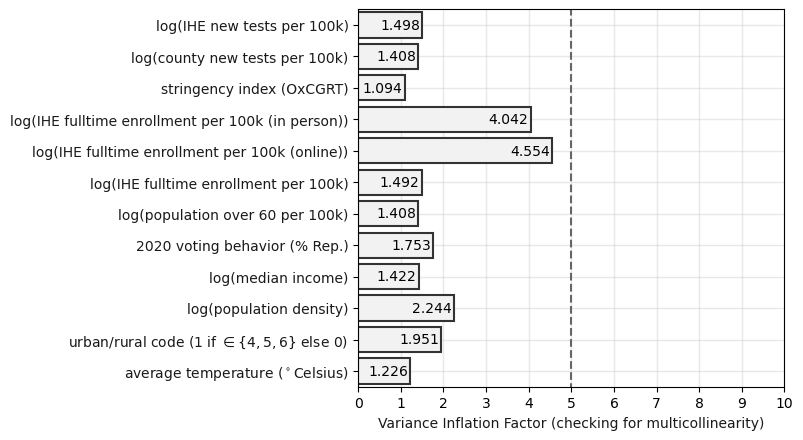

In [23]:
features = "+".join(exog_var)
y, X = dmatrices('%s ~'%endog_var[0] + features, out_dfx, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

fig, ax = plt.subplots(1,1,figsize=(5.5,5),dpi=100)

ax.barh(list(range(len(vif['VIF Factor'].values[1:]))),vif['VIF Factor'].values[1:],
        fc='.95',ec='.2',lw=1.5)
ax.vlines(5, -1, 12, color='.4', ls='--')
ax.set_xticks(list(range(11)))
ax.set_yticks(list(range(len(vif['VIF Factor'].values[1:]))))
ax.set_yticklabels([var_labels[i] for i in vif['features'].values[1:]], color='.1')
ax.set_xlabel('Variance Inflation Factor (checking for multicollinearity)', color='.1')
for ix,vi in enumerate(vif['VIF Factor'].values[1:].round(3)):
    ax.text(vi-0.05,ix,vi,ha='right',va='center')

ax.grid(linewidth=1.0, color='.75', alpha=0.35)
ax.set_xlim(0, 10)
ax.set_ylim(-0.5, vif.shape[0]-1.5)

# plt.savefig('../figs/pngs/regression_SI_campuscovid_VIF.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/regression_SI_campuscovid_VIF.pdf',bbox_inches='tight')
plt.show()

___________

# Would an OLS work?

In [24]:
out_dfx = df.loc[df['fips'].isin(college_county_fips)].reset_index().iloc[:,1:].copy()
endog_df = out_dfx[['date']+endog_var].copy()
for endog_i in endog_var:
    endog_df[endog_i] = np.array(np.nan_to_num(endog_df[endog_i].values), dtype='float')

smdates = dates_from_str(endog_df['date'])
endog_df.index = pd.DatetimeIndex(smdates)
endog_df = endog_df[[i for i in endog_df.columns if i!='date']]

exog_df = out_dfx[['date']+exog_var].copy()
for exog_i in exog_var:
    exog_df[exog_i] = np.array(np.nan_to_num(exog_df[exog_i].values), dtype='float')

smdates = dates_from_str(exog_df['date'])
exog_df.index = pd.DatetimeIndex(smdates)
exog_df = exog_df[[i for i in exog_df.columns if i!='date']]
# exog_df = sm.add_constant(exog_df)

# run OLS
ols_model = sm.OLS(endog_df, exog_df)
ols_results = ols_model.fit()

ols_results_summary = ols_results.summary(xname=[var_labels[i]
                                                 for i in ols_model.data.xnames],
                                          yname=var_labels[endog_var[0]])
ols_results_as_html = ols_results_summary.tables[1].as_html()
ols_res_i = pd.read_html(ols_results_as_html, header=0, index_col=0)[0]
ols_res_i = ols_res_i.reset_index()
ols_res_i.columns = ['var','coef','std_err','z','pval','ci025','ci975']
ols_results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     new deaths per 100k, 38-day lag   R-squared (uncentered):                   0.349
Model:                                         OLS   Adj. R-squared (uncentered):              0.349
Method:                              Least Squares   F-statistic:                              2498.
Date:                             Thu, 02 Sep 2021   Prob (F-statistic):                        0.00
Time:                                     07:57:19   Log-Likelihood:                         -87643.
No. Observations:                            55965   AIC:                                  1.753e+05
Df Residuals:                                55953   BIC:                                  1.754e+05
Df Model:                                       12                                                  
Covariance Type:                         nonrobust                                                  
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
average temperature ($^\circ$Celsius)                -0.0277      0.001    -43.464      0.000      -0.029      -0.026
urban/rural code (1 if $\in \{4,5,6\}$ else 0)        0.0734      0.015      4.978      0.000       0.044       0.102
log(population density)                              -0.0127      0.005     -2.790      0.005      -0.022      -0.004
log(median income)                                   -0.2114      0.019    -11.262      0.000      -0.248      -0.175
2020 voting behavior (% Rep.)                         0.0075      0.000     21.233      0.000       0.007       0.008
log(population over 60 per 100k)                      0.3404      0.020     16.785      0.000       0.301       0.380
log(IHE fulltime enrollment per 100k)                -0.0788      0.008     -9.733      0.000      -0.095      -0.063
log(IHE fulltime enrollment per 100k (online))        0.0019      0.002      0.816      0.415      -0.003       0.006
log(IHE fulltime enrollment per 100k (in person))     0.0047      0.002      2.050      0.040       0.000       0.009
stringency index (OxCGRT)                            -0.0130      0.001    -19.237      0.000      -0.014      -0.012
log(county new tests per 100k)                        0.1882      0.007     28.183      0.000       0.175       0.201
log(IHE new tests per 100k)                          -0.0283      0.003     -9.665      0.000      -0.034      -0.023
==============================================================================
Omnibus:                    65924.670   Durbin-Watson:                   0.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16054460.304
Skew:                           5.985   Prob(JB):                         0.00
Kurtosis:                      85.107   Cond. No.                         468.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

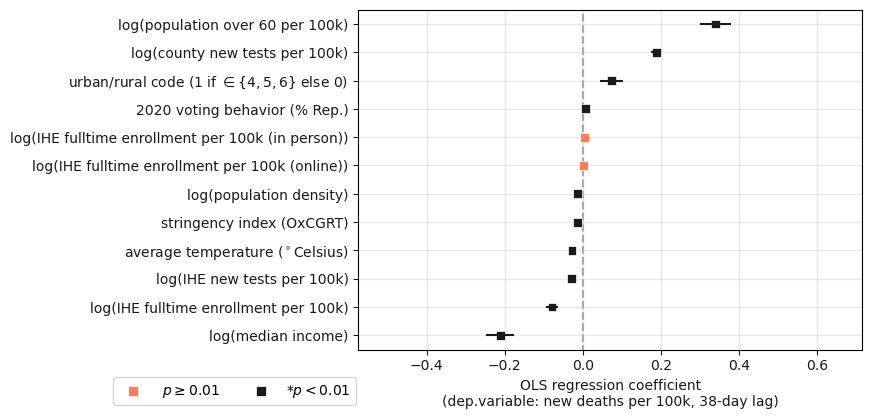

In [25]:
ols_res_i = ols_res_i.sort_values('coef', ascending=True).reset_index().iloc[:,1:]
pval_lim = 0.01
ols_res_i['color'] = '.1'
ols_res_i.loc[ols_res_i['pval']>pval_lim,'color'] = 'coral'

fig, ax = plt.subplots(1,1,figsize=(6.5,4.5),dpi=100)

ax.scatter([-50],[0],
           marker='s',lw=0.5,s=50, c='coral', ec='w',label=r' $p \geq 0.01$')
ax.scatter([-50],[0],
           marker='s',lw=0.5,s=50, c='.1', ec='w',label=r'$*p < 0.01$')
ax.legend(loc=2, bbox_to_anchor=[-0.5,-0.06], ncol=2)

ax.scatter(ols_res_i['coef'].values, list(range(ols_res_i.shape[0])),
           marker='s',lw=0.5,s=40, color=ols_res_i['color'].values, ec='w')
ax.hlines(list(range(ols_res_i.shape[0])),
          ols_res_i['ci025'].values,
          ols_res_i['ci975'].values, color=ols_res_i['color'].values)
ax.vlines(0, -1, len(list(range(res_i.shape[0])))+0.5,
          color='.4', linestyle='--', zorder=0, alpha=0.6)

ax.tick_params(labelcolor='.1', color='.1')
ax.set_yticks(list(range(ols_res_i.shape[0])))
ax.set_yticklabels([i for i in ols_res_i['var'].values], color='.1')
ax.set_ylim(-0.5, len(list(range(ols_res_i.shape[0])))-0.5)
ax.grid(linewidth=1.0, color='.75', alpha=0.35)
ax.set_xlabel('OLS regression coefficient\n(dep.'+\
              'variable: %s)'%var_labels[endog_var[0]], color='.1')
ax.set_xlim(-0.575, 0.715)

# plt.savefig('../figs/pngs/regression_SI_campuscovid_OLS.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/regression_SI_campuscovid_OLS.pdf',bbox_inches='tight')
plt.show()

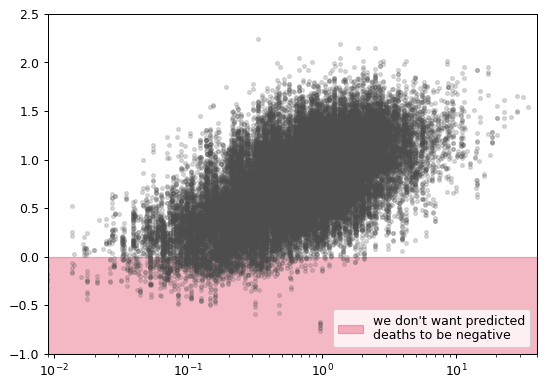

In [26]:
plt.figure(figsize=(7,5),dpi=90)
plt.semilogx(endog_df['county_new_deaths_per100k_lagged_38'],
             ols_results.fittedvalues,lw=0,marker='.',alpha=0.2,color='.3')
plt.fill_between([9e-3,4e1],0,-1, color='crimson',alpha=0.3,label="we don't want predicted\n"+\
                 "deaths to be negative")
plt.legend()
plt.xlim(9e-3,4e1)
plt.ylim(-1,2.5)

plt.show()